In [1]:
import tensorflow as tf
import keras as keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import boston_housing
from sklearn.datasets import load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.regularizers import l1_l2

In [16]:
import lifelines
from sksurv.datasets import load_whas500
from sksurv.metrics import concordance_index_censored

Boston Housing Dataset Example

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [5]:
train_data_df = pd.DataFrame(train_data)
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [6]:
train_data.mean(axis=0)

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [7]:
# Normalizing the data
mean = train_data.mean(axis=0)  # obtain mean of each column
# the parameter axis=0 is used to specify that the mean should be calculated column-wise (across the rows for each column) when normalizing the data. 
train_data -= mean # centralization
std = train_data.std(axis=0)
train_data /= std

# Note that the quantities used for normalizing the test data are computed using the training data. 
# You should never use in your workflow any quantity computed on the test data.
test_data -= mean
test_data /= std

In [8]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error']) # Mean absolute error
    return model

In [9]:
# 3 Fold Cross Validation

k = 3
print(len(train_data))
num_val_samples = len(train_data) // k
print(num_val_samples)
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing Fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

404
134
Processing Fold  0


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold  1
Processing Fold  2


In [10]:
print(all_scores)
print(np.mean(all_scores))
np.std(all_scores)

[2.676415205001831, 2.295450210571289, 2.4999241828918457]
2.4905965328216553


0.15566809893111191

In [11]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    # When axis=0, the function concatenates arrays vertically (i.e., by stacking rows one after the other). 
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model() # already defined in the above cell #128
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    # verbose=0 means that no output will be printed during the training process
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2


In [12]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

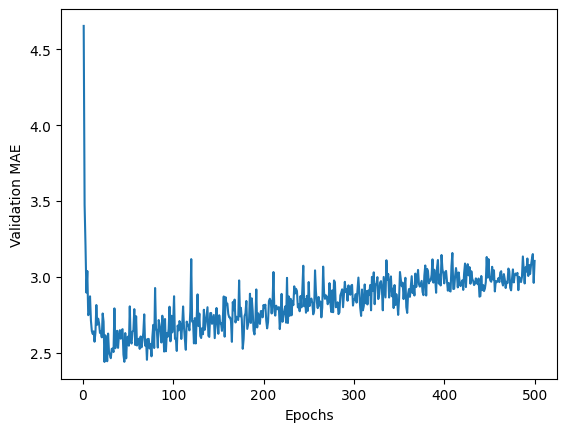

In [13]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [15]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

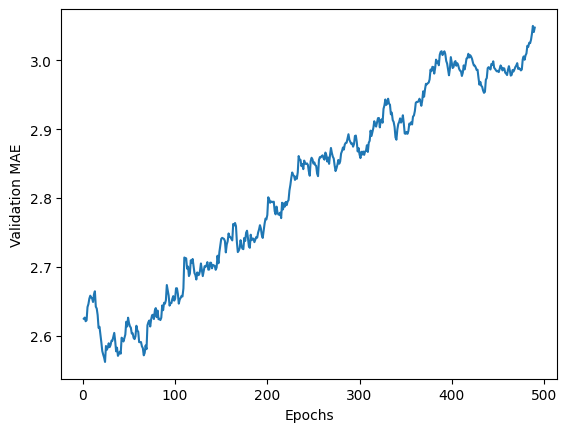

In [16]:
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [17]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.5447 - mean_absolute_error: 2.3898
2.599677562713623


In [20]:
data = load_diabetes()
print(data.keys())

X = data.data
y = data.target

print(X.shape)
print(y.shape)

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])
(442, 10)
(442,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
def build_model_with_elastic_net():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],),
                              kernel_regularizer= l1_l2(l1=0.001, l2=0.001)),

        tf.keras.layers.Dense(64, activation = "relu", kernel_regularizer= l1_l2(l1=0.001, l2=0.001)),
        tf.keras.layers.Dense(1, activation="linear")
        ])
    model.compile(optimizer="Adam",
                  loss="mean_squared_error",
                  metrics=["mean_absolute_error"])
    return model

model = build_model_with_elastic_net()

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/50
9/9 - 1s - 125ms/step - loss: 31402.7598 - mean_absolute_error: 158.3203 - val_loss: 22274.0859 - val_mean_absolute_error: 133.3634
Epoch 2/50
9/9 - 0s - 7ms/step - loss: 31169.3008 - mean_absolute_error: 157.5924 - val_loss: 22067.6836 - val_mean_absolute_error: 132.6123
Epoch 3/50
9/9 - 0s - 7ms/step - loss: 30889.4180 - mean_absolute_error: 156.7295 - val_loss: 21816.6328 - val_mean_absolute_error: 131.6964
Epoch 4/50
9/9 - 0s - 7ms/step - loss: 30532.0957 - mean_absolute_error: 155.6064 - val_loss: 21488.0039 - val_mean_absolute_error: 130.5028
Epoch 5/50
9/9 - 0s - 7ms/step - loss: 30039.8574 - mean_absolute_error: 154.1213 - val_loss: 21061.0898 - val_mean_absolute_error: 128.9409
Epoch 6/50
9/9 - 0s - 7ms/step - loss: 29391.2520 - mean_absolute_error: 152.1296 - val_loss: 20500.3828 - val_mean_absolute_error: 126.8843
Epoch 7/50
9/9 - 0s - 7ms/step - loss: 28546.3359 - mean_absolute_error: 149.5059 - val_loss: 19772.8594 - val_mean_absolute_error: 124.1928
Epoch 8/50


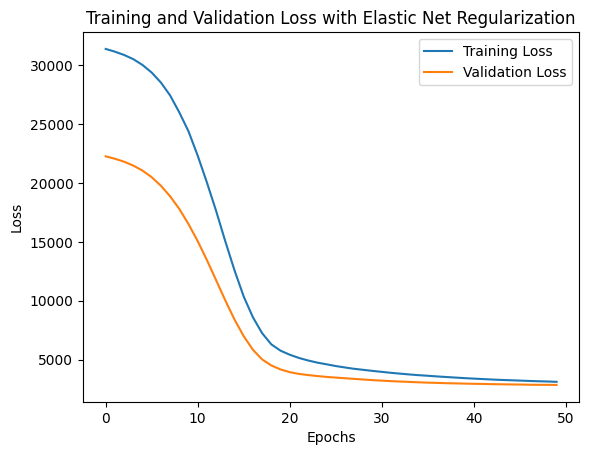

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Elastic Net Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print('Test Mean Absolute Error:', test_mae)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3483.1199 - mean_absolute_error: 47.3478 
Test Mean Absolute Error: 45.36021041870117


In [32]:
model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/30
9/9 - 0s - 10ms/step - loss: 3084.1021 - mean_absolute_error: 43.8138 - val_loss: 2833.0991 - val_mean_absolute_error: 40.7324
Epoch 2/30
9/9 - 0s - 7ms/step - loss: 3064.6887 - mean_absolute_error: 43.6880 - val_loss: 2828.6284 - val_mean_absolute_error: 40.7194
Epoch 3/30
9/9 - 0s - 7ms/step - loss: 3046.7502 - mean_absolute_error: 43.5491 - val_loss: 2825.6230 - val_mean_absolute_error: 40.8650
Epoch 4/30
9/9 - 0s - 9ms/step - loss: 3027.6802 - mean_absolute_error: 43.4454 - val_loss: 2823.5110 - val_mean_absolute_error: 40.9428
Epoch 5/30
9/9 - 0s - 7ms/step - loss: 3007.3137 - mean_absolute_error: 43.3114 - val_loss: 2818.4592 - val_mean_absolute_error: 40.9407
Epoch 6/30
9/9 - 0s - 7ms/step - loss: 2994.4810 - mean_absolute_error: 43.2406 - val_loss: 2808.1438 - val_mean_absolute_error: 40.8915
Epoch 7/30
9/9 - 0s - 7ms/step - loss: 2974.5703 - mean_absolute_error: 43.1127 - val_loss: 2802.1492 - val_mean_absolute_error: 40.9198
Epoch 8/30
9/9 - 0s - 9ms/step - loss: 2

In [33]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print('Test Mean Absolute Error:', test_mae)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3111.9443 - mean_absolute_error: 44.4674 
Test Mean Absolute Error: 43.0986442565918


In [35]:
# We will now add Dropout with the Iris dataset. 

data = load_iris()
X = data.data
y = data.target 
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [37]:
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

In [38]:
print(y.shape)

(150, 3)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
def build_classification_model_with_regularization():
    model = tf.keras.Sequential([
        # First hidden layer with Elastic Net (L1 + L2) and ReLU activation
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                     kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        # Add Dropout layer with 20% dropout rate
        tf.keras.layers.Dropout(0.3),
        
        # Second hidden layer with Elastic Net (L1 + L2) and ReLU activation
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        # Add another Dropout layer with 30% dropout rate
        tf.keras.layers.Dropout(0.3),
        
        # Output layer for classification (Softmax activation for multi-class classification)
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
                  metrics=['accuracy'])
    return model

# Build the model
model = build_classification_model_with_regularization()

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/50
6/6 - 1s - 226ms/step - accuracy: 0.1771 - loss: 1.8618 - val_accuracy: 0.4167 - val_loss: 1.6863
Epoch 2/50
6/6 - 0s - 10ms/step - accuracy: 0.3542 - loss: 1.6453 - val_accuracy: 0.6250 - val_loss: 1.5452
Epoch 3/50
6/6 - 0s - 9ms/step - accuracy: 0.6146 - loss: 1.4812 - val_accuracy: 0.7500 - val_loss: 1.4257
Epoch 4/50
6/6 - 0s - 9ms/step - accuracy: 0.7083 - loss: 1.3544 - val_accuracy: 0.7500 - val_loss: 1.3191
Epoch 5/50
6/6 - 0s - 10ms/step - accuracy: 0.6667 - loss: 1.2918 - val_accuracy: 0.7500 - val_loss: 1.2361
Epoch 6/50
6/6 - 0s - 10ms/step - accuracy: 0.7604 - loss: 1.1916 - val_accuracy: 0.7500 - val_loss: 1.1612
Epoch 7/50
6/6 - 0s - 10ms/step - accuracy: 0.8229 - loss: 1.1342 - val_accuracy: 0.8750 - val_loss: 1.0965
Epoch 8/50
6/6 - 0s - 10ms/step - accuracy: 0.7708 - loss: 1.0695 - val_accuracy: 0.8750 - val_loss: 1.0325
Epoch 9/50
6/6 - 0s - 10ms/step - accuracy: 0.7708 - loss: 1.0088 - val_accuracy: 0.8750 - val_loss: 0.9843
Epoch 10/50
6/6 - 0s - 10ms/s

In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.3675
Test Accuracy: 1.0


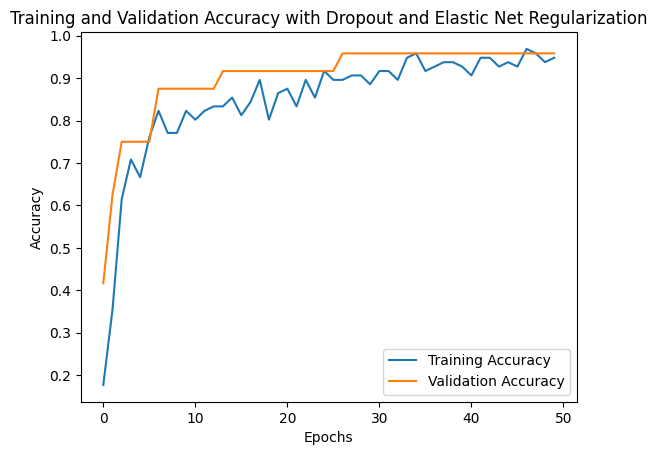

In [48]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy with Dropout and Elastic Net Regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/20
6/6 - 0s - 14ms/step - accuracy: 0.9375 - loss: 0.4210 - val_accuracy: 0.9583 - val_loss: 0.4151
Epoch 2/20
6/6 - 0s - 10ms/step - accuracy: 0.9479 - loss: 0.4293 - val_accuracy: 0.9583 - val_loss: 0.4175
Epoch 3/20
6/6 - 0s - 10ms/step - accuracy: 0.9792 - loss: 0.3962 - val_accuracy: 0.9583 - val_loss: 0.4117
Epoch 4/20
6/6 - 0s - 10ms/step - accuracy: 0.9688 - loss: 0.3972 - val_accuracy: 0.9583 - val_loss: 0.4039
Epoch 5/20
6/6 - 0s - 10ms/step - accuracy: 0.9583 - loss: 0.4000 - val_accuracy: 0.9583 - val_loss: 0.3962
Epoch 6/20
6/6 - 0s - 10ms/step - accuracy: 0.9479 - loss: 0.4027 - val_accuracy: 0.9583 - val_loss: 0.3992
Epoch 7/20
6/6 - 0s - 10ms/step - accuracy: 0.9479 - loss: 0.4076 - val_accuracy: 0.9583 - val_loss: 0.3851
Epoch 8/20
6/6 - 0s - 9ms/step - accuracy: 0.9583 - loss: 0.3924 - val_accuracy: 0.9583 - val_loss: 0.3725
Epoch 9/20
6/6 - 0s - 10ms/step - accuracy: 0.9479 - loss: 0.3882 - val_accuracy: 0.9583 - val_loss: 0.3671
Epoch 10/20
6/6 - 0s - 10ms/s

In [50]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.2933
Test Accuracy: 1.0


FNN for Survival Analysis

In [3]:
data_x, data_y = load_whas500()
df_x = pd.DataFrame(data_x)
df_y = pd.DataFrame(data_y)
df_x.head()

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0


In [4]:
df_y.head()

,fstat,lenfol
0,False,2178.0
1,False,2172.0
2,False,2190.0
3,True,297.0
4,False,2131.0


In [5]:
# Combine time and event indicator with features. 

df_y['time'] = df_y['lenfol']
df_y['event'] = df_y['fstat']
df_y = df_y[['time', 'event']]
print(df_x.head())
print(df_y.head())

  afb   age av3       bmi chf cvd  diasbp gender    hr   los miord mitype sho  \
0   1  83.0   0  25.54051   0   1    78.0      0  89.0   5.0     1      0   0   
1   0  49.0   0  24.02398   0   1    60.0      0  84.0   5.0     0      1   0   
2   0  70.0   0  22.14290   0   0    88.0      1  83.0   5.0     0      1   0   
3   0  70.0   0  26.63187   1   1    76.0      0  65.0  10.0     0      1   0   
4   0  70.0   0  24.41255   0   1    85.0      0  63.0   6.0     0      1   0   

   sysbp  
0  152.0  
1  120.0  
2  147.0  
3  123.0  
4  135.0  
     time  event
0  2178.0  False
1  2172.0  False
2  2190.0  False
3   297.0   True
4  2131.0  False


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
def cox_ph_loss(y_true, y_pred):
    time = y_true[:, 0]
    event = y_true[:, 1]
    order = tf.argsort(time)
    time = tf.gather(time, order)
    event = tf.gather(event, order)
    y_pred = tf.gather(y_pred, order)

    risk = tf.math.exp(y_pred)
    cum_risk = tf.math.cumsum(risk[::-1])[::-1]
    log_likelihood = tf.reduce_sum(event * (y_pred - tf.math.log(cum_risk + 1e-9)))
    return -log_likelihood

In [13]:
def build_survival_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation="relu", input_shape=input_shape),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation=None)
    ])
    model.compile(optimizer='adam', loss=cox_ph_loss)
    return model

input_shape = (X_train.shape[1],)
model = build_survival_model(input_shape)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Prepare the labels for training. 

y_train_prepared = np.vstack([y_train["time"].values, y_train["event"].values]).T
y_test_prepared = np.vstack([y_test["time"].values, y_test["event"].values]).T

In [15]:
history = model.fit(X_train, y_train_prepared, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50
10/10 - 2s - 175ms/step - loss: 1117.3076 - val_loss: 985.3134
Epoch 2/50
10/10 - 0s - 13ms/step - loss: 1097.3359 - val_loss: 984.9283
Epoch 3/50
10/10 - 0s - 25ms/step - loss: 1081.7885 - val_loss: 986.2072
Epoch 4/50
10/10 - 0s - 10ms/step - loss: 1073.5173 - val_loss: 988.4362
Epoch 5/50
10/10 - 0s - 11ms/step - loss: 1064.6237 - val_loss: 990.5159
Epoch 6/50
10/10 - 0s - 10ms/step - loss: 1058.1193 - val_loss: 992.7952
Epoch 7/50
10/10 - 0s - 10ms/step - loss: 1050.0847 - val_loss: 996.4790
Epoch 8/50
10/10 - 0s - 16ms/step - loss: 1043.1235 - val_loss: 1001.8789
Epoch 9/50
10/10 - 0s - 14ms/step - loss: 1034.7571 - val_loss: 1005.3466
Epoch 10/50
10/10 - 0s - 15ms/step - loss: 1029.9006 - val_loss: 1010.5044
Epoch 11/50
10/10 - 0s - 12ms/step - loss: 1029.1482 - val_loss: 1012.8084
Epoch 12/50
10/10 - 0s - 13ms/step - loss: 1025.1472 - val_loss: 1016.5954
Epoch 13/50
10/10 - 0s - 16ms/step - loss: 1012.5352 - val_loss: 1022.9573
Epoch 14/50
10/10 - 0s - 11ms/step - los

In [17]:
risk_scores = model.predict(X_test)
c_index = concordance_index_censored(y_test["event"], y_test["time"], -risk_scores.flatten())
print(f"Concordance Index: {c_index[0]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Concordance Index: 0.31239446133063153


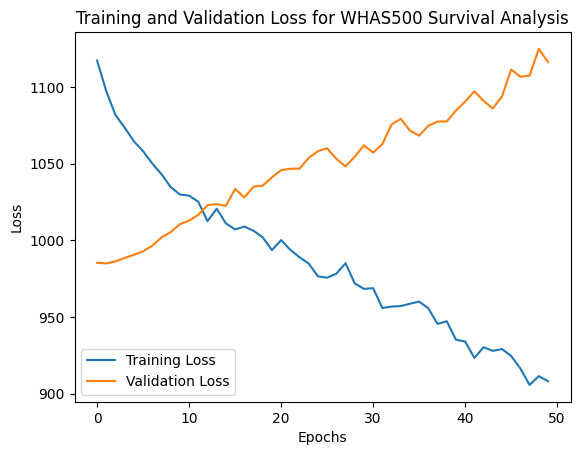

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss for WHAS500 Survival Analysis")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()